In [1]:
'''
pytorch Fashion_MNIST Dropout
'''

'\npytorch Fashion_MNIST Dropout\n'

In [2]:
#dataset : 이미지셋 제공 / 데이터의 용도 / 위치 등 지정
#dataloader : 전처리 / 파라미터 지정
#utils : 이미지 시각화 도구
from torchvision import datasets, transforms, utils
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
#gpu 사용시
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

In [5]:
EPOCHS = 50
BATCH_SIZE = 64

In [7]:
#root = 위치 / train = True면 학습용 데이터 (false면 성능 평가용)
#download = True root 가 지정한 폴더에 데이터셋이 없으면 다운로드
trainset = datasets.FashionMNIST(
    root = './.data/',
    train= True,
    download = True,
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
])
)
testset = datasets.FashionMNIST(
    root = './.data/',
    train= False,
    download = True,
    transform = transforms.Compose([ 
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
])
)

In [8]:
train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle=True
)
test_loader = data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE,
    shuffle=True
)

In [9]:
#iter > for 문 형태처럼 next 다음 값으로 이동 
#리스트가 아닌 것을 리스트처럼 다룰 수 있다
#리스트가 생성되는 것이 아니므로 메모리 문제 X
dataiter = iter(train_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


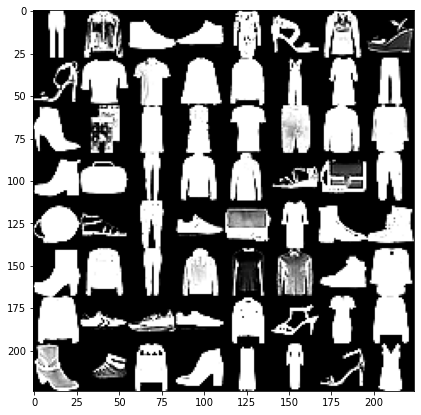

In [10]:
#make_grid 여러개 이미지 하나로 모아주는 함수
img = utils.make_grid(images,padding=0)
#matplotlib이 tensor type 과는 호환이 안되므로 np 로 변형
npimg = img.numpy()
plt.figure(figsize=(10,7))
#np.transpose(npimg,(npimg.shape[1],npimg.shape[2],npimg.shape[0])) 
plt.imshow(np.transpose(npimg,(1,2,0)))
plt.show()

In [11]:
print(labels)

tensor([1, 4, 7, 7, 3, 5, 2, 5, 5, 0, 0, 6, 4, 1, 3, 1, 9, 1, 0, 3, 0, 1, 6, 6,
        9, 8, 1, 6, 2, 5, 8, 1, 8, 5, 1, 7, 8, 3, 9, 9, 9, 2, 1, 2, 2, 6, 7, 6,
        6, 7, 7, 7, 4, 5, 3, 6, 9, 7, 4, 9, 3, 3, 5, 3])


In [12]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

(28, 28)


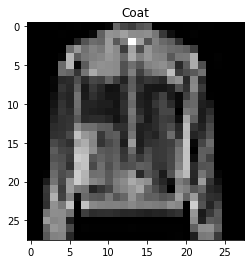

In [13]:
idx = 1
item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(classes[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')

In [16]:
class Net(nn.Module):
    def __init__(self,dropout_p = 0.2):
        super(Net,self).__init__()
        #Linear(input node 수 , output node 수 )
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        #output = label 수
        self.fc3 = nn.Linear(128,10)
        self.dropout_p = dropout_p
    # x = input / shape = [BATCH_SIZE, 색, 행, 렬]
    def forward(self,x):
        # -1 non 처럼 이해 > 1차원 벡터 텐서로 flatten
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        
        x = F.dropout(x,training=self.training, p= self.dropout_p)
        x = F.relu(self.fc2(x)) 
        x = F.dropout(x,training=self.training, p= self.dropout_p)
        #linear
        x = self.fc3(x)
        return x

In [17]:
#to() 를 이용해 모델 파라미터를 gpu로 보내주는 역할
model = Net(dropout_p = 0.2).to(DEVICE)
#parameters() 모델의 멤버인 3개의 nn.Linear 모듈의 학습 가능한 매개변수들이 포함됩니다.
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [18]:
def train(model, train_loader, optimizer):
    #모델을 학습 모드로 선언 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #model에 사용한 장치 이용
        data, target = data.to(DEVICE), target.to(DEVICE)
        #batch 마다 기울기 새로 계산 위해 초기화
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        #기울기 계산
        loss.backward()
        optimizer.step()

In [19]:
def evaluate(model, test_loader):
    #평가모드 / dropout 안됨
    model.eval()
    test_loss = 0
    correct = 0
    # 기울기 계산 필요없음
    with torch.no_grad():
        for data, target in test_loader:
            data , target = data.to(DEVICE),target.to(DEVICE)
            output = model(data)
            
            #평균 대신 sum 을 받아오므로 값을 계속 더해줌 / item 1개 값을 가진 텐서를 가져옴
            test_loss += F.cross_entropy(output, target, reduction = 'sum').item()
            #특정 차원 단위에서 최대값 반환 / [0] 최대값 /[1] 인덱스 반환
            pred = output.max(1, keepdim=True)[1]
            # eq 같으면 1 다르면 0 > 다 더하면 정답 맞춘 개수
            #target.view_as(pred) > target 을 pred와 형태 맞춰줌
            correct += pred.eq(target.view_as(pred)).sum().item()
    #평균
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
for epoch in range(1,EPOCHS+1):
    train(model, train_loader , optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f'[{epoch}] Test Loss : {round(test_loss, 4)} Accuracy : {round(test_accuracy, 3)}')

[1] Test Loss : 0.5651 Accuracy : 80.37
[2] Test Loss : 0.5202 Accuracy : 82.26
[3] Test Loss : 0.5305 Accuracy : 81.45
[4] Test Loss : 0.5266 Accuracy : 82.17
[5] Test Loss : 0.5242 Accuracy : 82.34
[6] Test Loss : 0.614 Accuracy : 81.89
[7] Test Loss : 0.508 Accuracy : 83.34
[8] Test Loss : 0.5099 Accuracy : 82.48
[9] Test Loss : 0.5395 Accuracy : 82.31
[10] Test Loss : 0.535 Accuracy : 81.63
[11] Test Loss : 0.5689 Accuracy : 80.53
[12] Test Loss : 0.5294 Accuracy : 81.45
[13] Test Loss : 0.5774 Accuracy : 80.9
[14] Test Loss : 0.5168 Accuracy : 83.51
[15] Test Loss : 0.6122 Accuracy : 82.53
[16] Test Loss : 0.5375 Accuracy : 82.88
[17] Test Loss : 0.608 Accuracy : 82.82
[18] Test Loss : 0.6404 Accuracy : 82.02
[19] Test Loss : 0.5704 Accuracy : 80.49
[20] Test Loss : 0.5349 Accuracy : 80.74
[21] Test Loss : 0.5588 Accuracy : 81.73
[22] Test Loss : 0.6131 Accuracy : 81.42
[23] Test Loss : 0.5749 Accuracy : 83.17
[24] Test Loss : 0.5363 Accuracy : 82.75
[25] Test Loss : 0.56 Accuracy